# In-Group Imitation Model

In [4]:
from utils import *

In [158]:
from scipy import optimize

In [5]:
df = pd.read_feather('data/names.feather').set_index(['year', 'name', 'gender'])

In [6]:
pct_df = df / df.groupby('year').transform(sum)

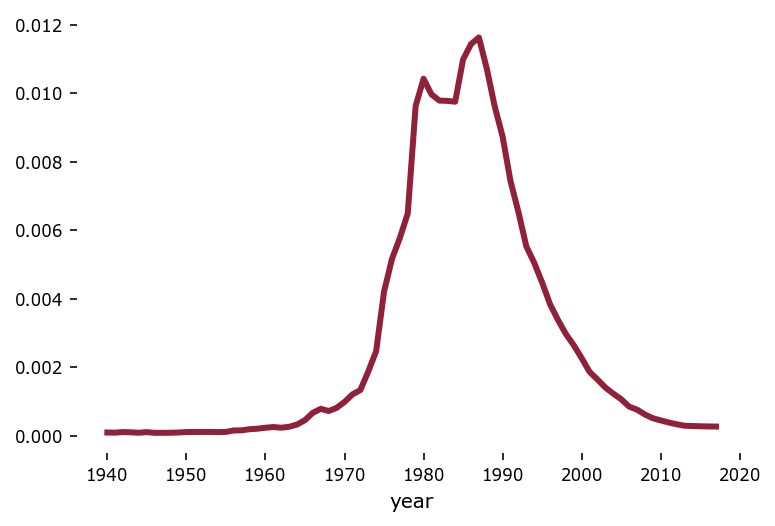

In [148]:
amanda = get_name_series('Amanda', pct_df).loc[1940:]
amanda.plot()

In [46]:
# size of in-group as a percent of total population
p_in = .5

# number of births per year
N = int(1.5e6)

in_initial = .005
in_carry = .05
out_initial = 0.0005
out_lag = 10
omega = 5

alpha = 3.2
beta = 4.5

N_time = 150

In [ ]:
[.5, .005, .05, .0005, 10, 5, 3.2, 4.5]

In [86]:
def gen_sim(
        p_in = .5,
        in_initial = .005,
        in_carry = .05,
        out_initial = 0.0005,
        out_lag = 10,
        omega = 5,
        alpha = 3.2,
        beta = 4.5):
    in_p = [in_initial]
    out_p = [out_initial]

    for i in range(N_time):
        if in_p[-1] < 0:
            dIndt = - in_p[-1]
        else:
            dIndt = alpha * in_p[-1] * (in_carry - in_p[-1] - omega*out_p[-1])
        if len(in_p) > out_lag:
            dOutdt = beta * out_p[-1] * (in_p[-out_lag] - out_p[-out_lag])
        else:
            dOutdt = 0
        in_p.append(in_p[-1] + dIndt)
        out_p.append(out_p[-1] + dOutdt)

    sim = pd.DataFrame({'in': in_p, 'out': out_p})
    sim['total'] = p_in * sim['in'] + (1-p_in)*sim['out']
    return sim


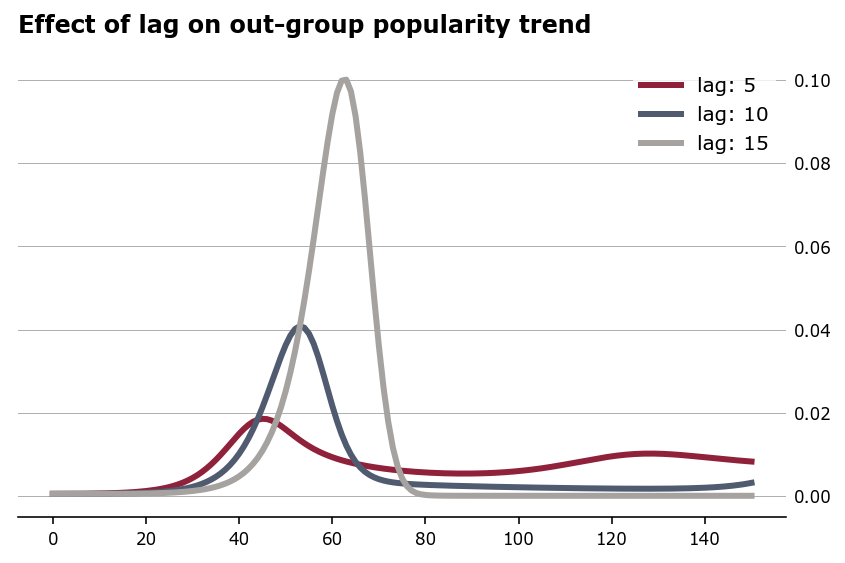

In [78]:
for out_lag in [5, 10, 15]:
    plt.plot(gen_sim(out_lag=out_lag).out, label=f'lag: {out_lag}')
plt.legend()
ft_ax(title=r'Effect of lag on out-group popularity trend')
plt.savefig('report/figs/out-lag.pdf')

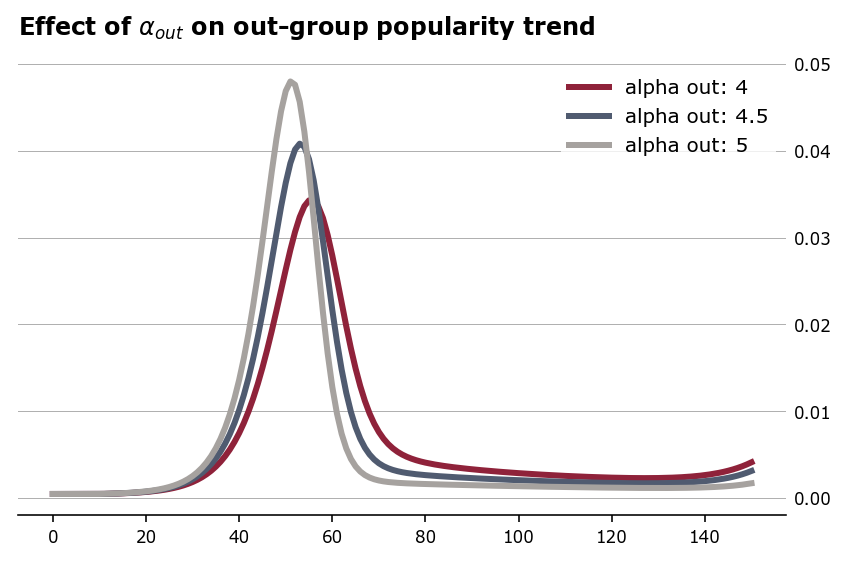

In [77]:
for alpha_out in [4, 4.5, 5]:
    plt.plot(gen_sim(beta=alpha_out).out, label=f'alpha out: {alpha_out}')
plt.legend()
ft_ax(title=r'Effect of $\alpha_{out}$ on out-group popularity trend')
plt.savefig('report/figs/alpha-out.pdf')

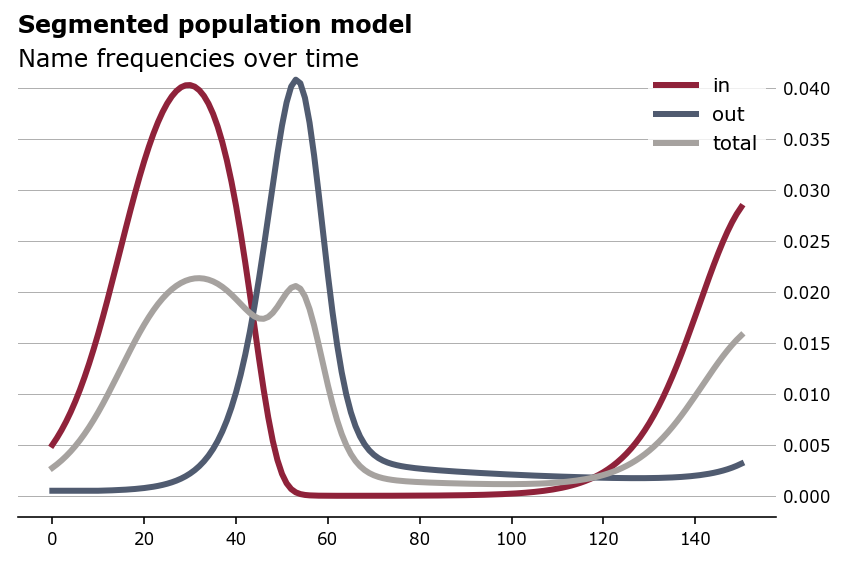

In [49]:
sim.plot()
ft_ax(title='Segmented population model', subtitle='Name frequencies over time')
plt.savefig('report/figs/segmented-model.pdf')
plt.savefig('slides/img/segmented-model.png', dpi=400)

In [11]:
# size of in-group as a percent of total population
p_in = .5

# number of births per year
N = int(1.5e6)

in_initial = .005
in_carry = .05
out_lag = 20
omega = 1

alpha = 3

N_time = 150

In [12]:
in_p = [in_initial]

for i in range(N_time):
    if len(in_p) > out_lag:
        dIndt = alpha * in_p[-1] * (in_carry - in_p[-1] - omega * in_p[-out_lag])
    else:
        dIndt = alpha * in_p[-1] * (in_carry - in_p[-1])
    in_p.append(in_p[-1] + dIndt)
    #in_p[-1] += np.random.normal(0, np.sqrt(in_p[-1] * (1-in_p[-1]) / (N*p_in)))

sim = pd.DataFrame({'in': in_p})
sim['out'] = sim['in'].shift(out_lag).fillna(0)
sim['total'] = p_in * sim['in'] + (1-p_in)*sim['out']

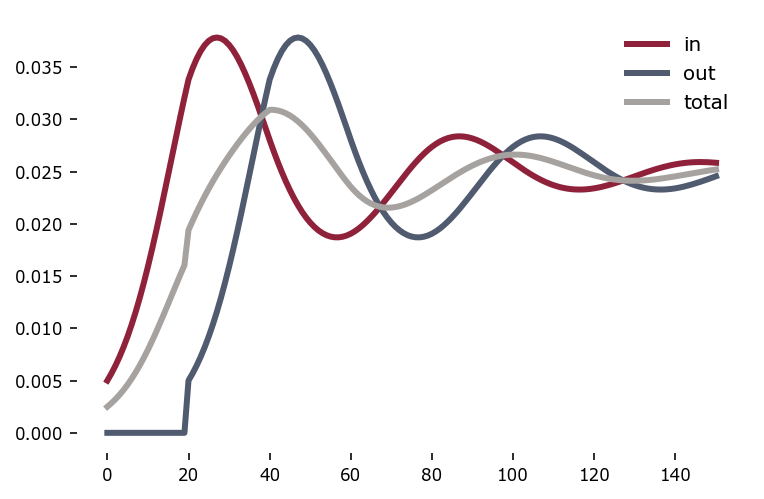

In [13]:
sim.plot()

## Fit the model

In [231]:
amanda = get_name_series('Amanda', pct_df).loc[1955:]

In [238]:
N_time = len(amanda) - 1
name_series = amanda
out_lag = 3

def gen_sim(
        p_in = .5,
        in_initial = .005,
        in_carry = .05,
        out_initial = 0.0005,
        omega = 5,
        alpha = 3.2,
        beta = 4.5):
    in_p = [in_initial]
    out_p = [out_initial]

    for i in range(N_time):
        if in_p[-1] < 0:
            dIndt = - in_p[-1]
        else:
            dIndt = alpha * in_p[-1] * (in_carry - in_p[-1] - omega*out_p[-1])
        if len(in_p) > out_lag:
            dOutdt = beta * out_p[-1] * (in_p[-out_lag] - out_p[-out_lag])
        else:
            dOutdt = 0
        in_p.append(in_p[-1] + dIndt)
        out_p.append(out_p[-1] + dOutdt)

    sim = pd.DataFrame({'in': in_p, 'out': out_p})
    sim['total'] = p_in * sim['in'] + (1-p_in)*sim['out']
    return sim


def loss(params):
#     p_in = params[0]
#     in_initial = params[1]
#     in_carry = params[2]
#     out_initial = params[3]
#     out_lag = params[4]
#     omega = params[5]
#     alpha = params[6]
#     beta = params[7]
    
    pred = gen_sim(*params)
    return np.sum((np.array(pred.total) - np.array(amanda))**2)
    

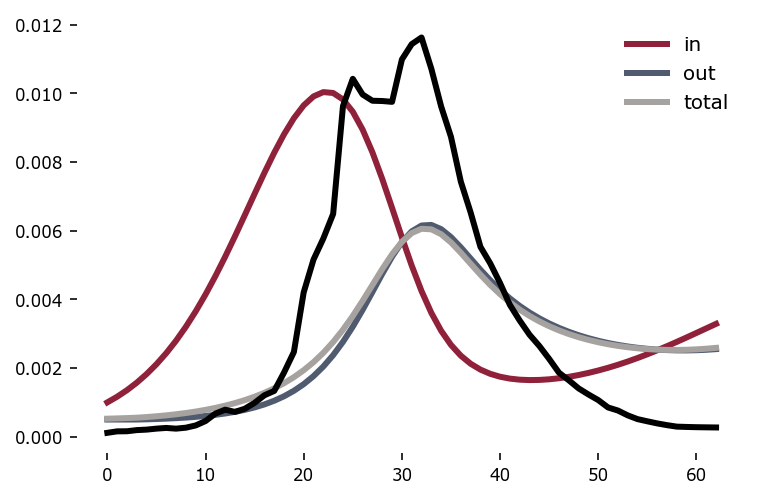

In [240]:
x0 = np.array([.05, .001, .02, .0005, 5, 10, 20])
gen_sim(*x0).plot()
plt.plot(np.array(amanda), c='k', label='Amanda trend')

In [234]:
o = optimize.minimize(loss, x0, method='Nelder-Mead', tol=1e-6, options={'maxiter':10000})
o

 final_simplex: (array([[  2.47584724e-01,   2.84429172e-07,   4.40583248e-02,
          1.04971330e-03,   6.35895793e+00,   1.83971071e+01,
          1.40220814e+01],
       [  2.47584736e-01,   2.84429178e-07,   4.40583231e-02,
          1.04971335e-03,   6.35895751e+00,   1.83971075e+01,
          1.40220822e+01],
       [  2.47584732e-01,   2.84429167e-07,   4.40583238e-02,
          1.04971334e-03,   6.35895765e+00,   1.83971074e+01,
          1.40220819e+01],
       [  2.47584734e-01,   2.84429194e-07,   4.40583231e-02,
          1.04971334e-03,   6.35895748e+00,   1.83971073e+01,
          1.40220822e+01],
       [  2.47584735e-01,   2.84429137e-07,   4.40583239e-02,
          1.04971334e-03,   6.35895760e+00,   1.83971076e+01,
          1.40220818e+01],
       [  2.47584739e-01,   2.84429078e-07,   4.40583241e-02,
          1.04971334e-03,   6.35895752e+00,   1.83971079e+01,
          1.40220816e+01],
       [  2.47584730e-01,   2.84429177e-07,   4.40583239e-02,
          1.049

In [235]:
x = np.array([  
        2.47584724e-01,   
        2.84429172e-07,   
        4.40583248e-02,
        1.04971330e-03,   
        6.35895793e+00,   
        1.83971071e+01,
        1.40220814e+01])

In [ ]:
   p_in = params[0]
#     in_initial = params[1]
#     in_carry = params[2]
#     out_initial = params[3]
#     out_lag = params[4]
#     omega = params[5]
#     alpha = params[6]
#     beta = params[7]
    
    pred = gen_sim(*params)

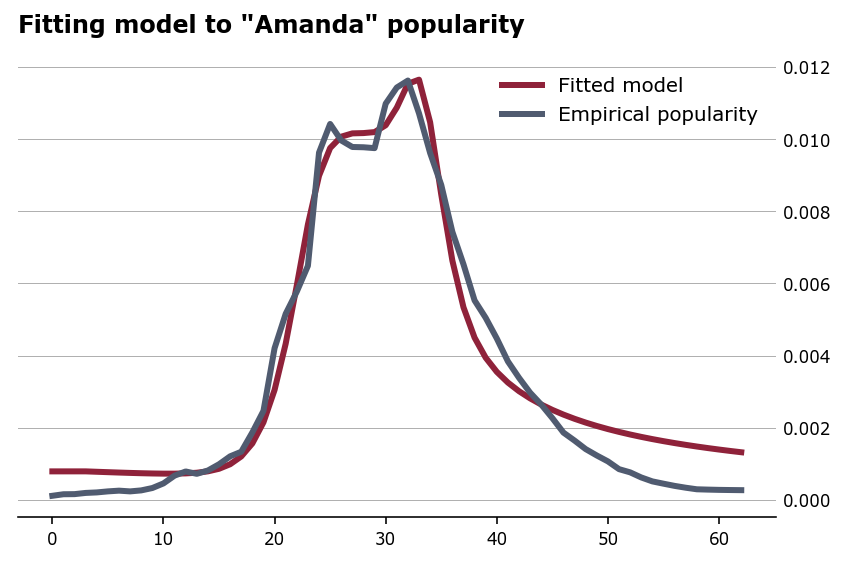

In [241]:
plt.plot(gen_sim(*x).total, label='Fitted model')
plt.plot(np.array(amanda), label='Empirical popularity')
plt.legend()
ft_ax(title='Fitting model to "Amanda" popularity')
plt.savefig('report/figs/amanda-fit.pdf')